<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/notebooks/clase_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Práctica 6: Formulación bayesiana de la regresión lineal

Cuando hablamos de regresión lineal, solemos imaginar:

$$ Y = β_xX+β_o$$

donde: **Y** es lo que queremos predecir (o variable dependiente), **X** es nuestro predictor (o variable independiente) y **β** son los coeficientes o parámetros del modelo que queremos estimar.

Utilizando  **Mínimos cuadrados ordinarios** o **Máxima verosimilitud**, se podría calcular las **estimaciones puntuales** de los parámetros.

Por otro lado, **desde un enfoque bayesiano**, no se trabaja con valores puntuales, sino con **distribuciones de probabilidad**, permitiendo modelar la incertidumbre en las estimaciones de los parámetros. 

De esta forma, la regresión lineal, se puede expresar:

$$ Y = β_xX+β_o+ϵ$$

con $$ ϵ \sim N \left( 0, \sigma^2 \right) $$

o su equivalente:

$$ Y \sim N \left( β_xX+β_o, \sigma^2 \right) $$

Siendo **Y** una **variable aleatoria** que se distribuye normalmente con **media βX + βo** y su **desvio estándar σ**.

### Pasos a seguir: 
- Analizar la data
- Definir un modelo Bayesiano
- Aplicar distintos algoritmos de MCMC sobre el modelo
- Revisar la convergencia
- Verificar el modelo posterior predictivo.

# Ejercicio 1 

Se dispone de una muestra de **26 puentes losa postesados macizos** y se desea conocer la relación existente entre la luz principal de este tipo de puentes y la altura del tablero. 

(Ver: https://victoryepes.blogs.upv.es/tag/correlacion/ )

Vamos a importar las librerias necesarias para realizar los ejercicios

In [ ]:
!pip install pymc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Importo las librerías
import numpy as np
import pandas as pd

import io

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import pymc as pm

In [ ]:
# Luz principal en metros
x = [ 
    30.00, 30.00, 30.00, 30.00, 22.50, 19.00, 22.50, 18.00, 18.00, 17.60, 20.00, 24.50, 19.00, 
    15.27, 15.20, 18.00, 20.40, 27.20, 20.50, 22.80, 18.85, 16.75, 18.50, 22.50, 22.00, 23.00
]

# Altura del tablero en metros
y = [
    1.10, 1.10, 1.10, 1.10, 0.90, 0.75, 0.90, 0.65, 0.65, 0.65, 0.80, 1.20, 0.75, 
    0.65, 0.65, 0.65, 0.75, 1.00, 0.75, 0.80, 0.85, 0.80, 0.80, 0.90, 1.00, 0.95
] 

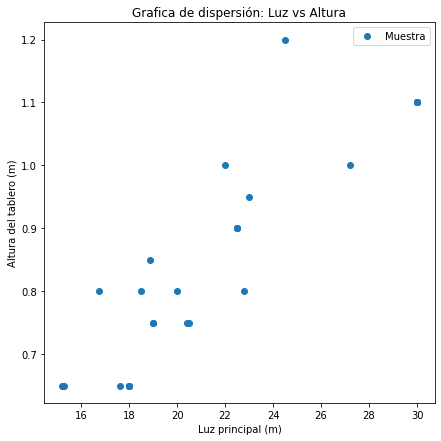

In [ ]:
#Gráfico:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='Luz principal (m)', ylabel='Altura del tablero (m)', title='Grafica de dispersión: Luz vs Altura')
ax.plot(x, y, 'o', label='Muestra')
plt.legend(loc=0);

Si analizamos la correlación entre las variables, observamos que es alta:

In [ ]:
pearsons_coefficient = np.corrcoef(x, y)
print("Coeficientes de correlación Pearson: \n" ,pearsons_coefficient)

Coeficientes de correlación Pearson: 
 [[1.         0.88642845]
 [0.88642845 1.        ]]


## Especificación del modelo

El modelo se crea dentro de un `with` y con `as` se lo denomina.

- **Prior:**
Para crear una variable aleatoria, se debes seleccionar una distribución: Normal, Bernoulli, etc, y especificar el nombre propio de la variable y los parámetros de la distriubución. 

- **Verosimilitud:** 
Se realiza de forma análoga a como se hace con las variables aleatorias, pero con `observed` y requiere proporcionarle datos ndarray de NunPy o DataFrame de pandas.


Para el ejercicio, se adoptó por una distribución normal con un gran desvío standard, para indicar el desconocimiento de la distribución:

$$  β_x, β_o\sim N \left( 0, 20\right) $$

Por otro lado, dado que σ² es un número positivo, elegimos una distribución con valores exclusivamente positivos, como:
- Exponencial
- Gamma
- SemiNormal
- SemiCauchy

In [ ]:
# Simulación (PyMC)
with pm.Model() as model:

    # Datos de entrada
    x_ = pm.MutableData("x", x)

    # Prior
    intercept = pm.Normal(name='intercept', mu=0, sigma=20)
    slope = pm.Normal(name='slope', mu=0, sigma=20)

    sigma = pm.Exponential(name='sigma', lam=1)
    
    #Variable determinista:
    mu = pm.Deterministic('mu', intercept + slope * x_)

    # Verosimilitud
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)


Si este modelo queremos utilizarlo para obtener predicciones, se deben utilizar entradas modificables con `pm.MutableData()`: básicamente le dice al modelo que use un marcador de posición `x_` que inicialmente se llenó con nuestros datos de entrenamiento x.

### Analisis del modelo

Con `pm.model_to_graphviz()` podemos observar el diagrama del modelo, que indica la relación de las variables y sus cantidades. 

Sus representaciones son: 

- las Variables deterministas con rectángulo

- las Variables aleatorias latentes o Priors con un círculo blanco

- las Variables aleatorias observadas o verosímilitud con un círculo gris


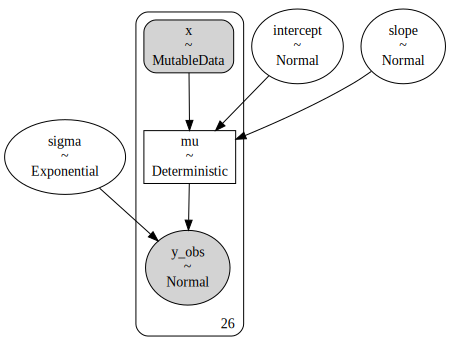

In [ ]:
pm.model_to_graphviz(model)

Un primer diagnóstico para asegurarnos de que nuestro modelo hace lo que queremos, es observar las muestra que están generando. Para ello, podemos muestrar desde los priors, usando la función `pm.sample_prior_predictive()`

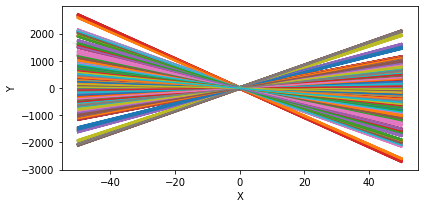

In [ ]:
# Viendo las rectas que se generar SIN LOS DATOS:
x_new = np.linspace(-50, 50, num=100)

with model:
    prior_checks = pm.sample_prior_predictive(samples=100, var_names=['intercept', 'slope'])

#Transformo los valores:
prior_checks_intercept = prior_checks.prior.intercept[0,:].to_numpy()
prior_checks_slope = prior_checks.prior.slope[0,:].to_numpy()

#Grafico: 
fig, ax = plt.subplots(figsize=(6,3), tight_layout=True)
ax.set_xlabel('X'); ax.set_ylabel('Y')

for intercept in prior_checks_intercept:
  for slope in prior_checks_slope:
    ax.plot(x_new, x_new*slope + intercept)

## Aplicación de los algoritmos de MCMC sobre el modelo

Utilizando `pm.sample()` podemos generar las muestras, siendo los parámetros más importantes:

    pm.sample(
          draws=500,      # Número de muestras del posterior
          tune=1000,      # Número de iteraciones iniciales que el algoritmo usa para calibrar el tamaño del salto en cada cadena
          steps=None,     # Algoritmos propuestos: pm.Metropolis(), pm.NUTS()
          chains=2,       # Número de cadenas para analizar su convergencia
          cores=2,        # Número de núcleos del CPU
          )
          

Nosotros probaremos:
- Con una muestra pequeña y dos cadenas: `draws=50, tune=1000, chains=2`,
- Con una muestra mayor: `draws=100, tune=1000, chains=2`,
- Con una muestra mayor y cambiando el  y dos cadenas: `draws=2000, tune=1000, chains=2`

In [ ]:
with model:
    # Inferencia por Cadenas de Markov
    trace = pm.sample(draws=2000, tune=2000, chains=4, return_inferencedata=True)

ERROR:pymc:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


### Diagnósticos visuales y numéricos:

- Podemos visualizar las posteriors y las muestras con `plot_trace()`:

En el gráfico de la izquierda, podemos ver la probabilidad de un cada valor del parámetro, y en el gráfico de la derecha, las cadenas de muestreo para los parámetros individuales que deben ser convergentes y de forma similar al ruido blanco.


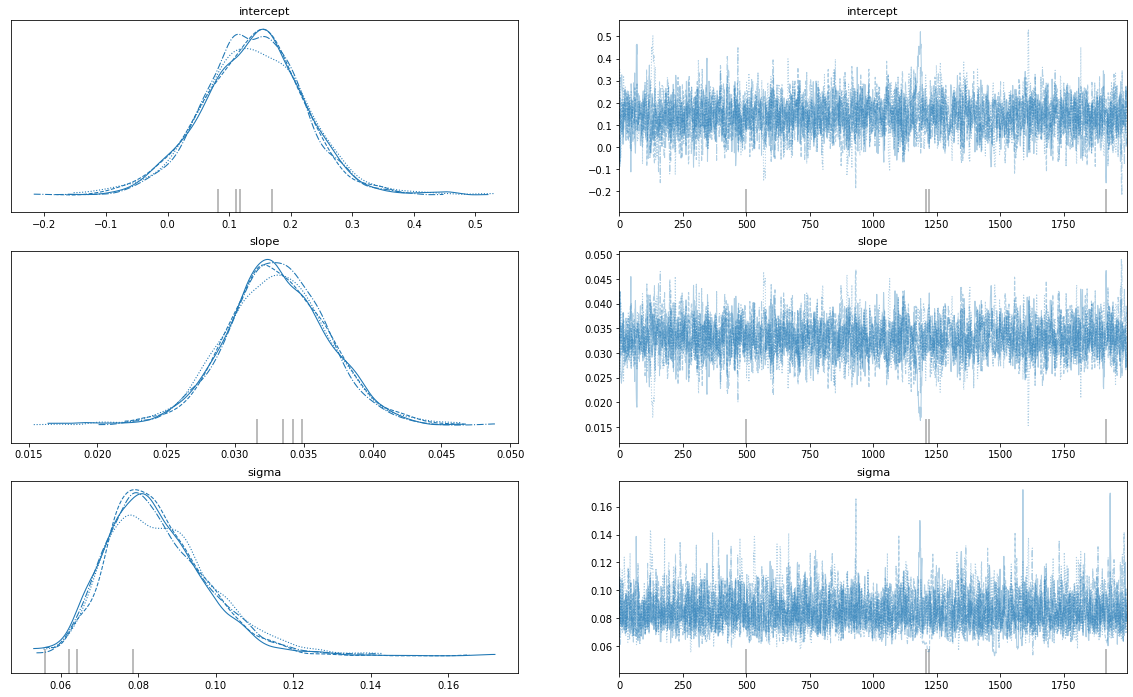

In [ ]:
pm.plot_trace(trace, figsize=(20,12), var_names=['intercept', 'slope', 'sigma']);

- Si sólo nos interesan los posteriores y sus descriptores podemos usar `plot_posterior()`:

El coeficiente `'slope'` expresa que por cada metro de luz, podemos esperar nominalmente un cambio de 0.033m en la altura (media), aunque también podría ocurrir razonablemente entre 0.026 y 0,04 m. 

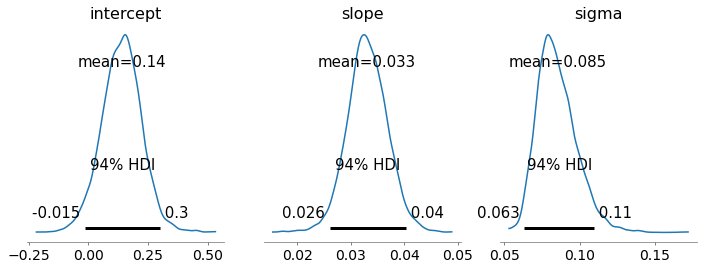

In [ ]:
pm.plot_posterior(trace, figsize=(12,4), var_names=['intercept', 'slope', 'sigma']);

- Un resumen tabular de lo anterior con `pm.summary()`:

donde `r_hat` es el estadístico de Gelman-Rubin, que permite comparar la varianza entre múltiples cadenas con la varianza interna de cada una, y valores mayores a 1 indican que una o más cadenas no han convergido. 


In [ ]:
pm.summary(trace,  var_names=['intercept', 'slope', 'sigma']).round(3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.140,0.084,-0.015,0.299,0.002,0.002,2219.0,1984.0,1.0
slope,0.033,0.004,0.026,0.040,0.000,0.000,2188.0,2007.0,1.0
sigma,0.085,0.013,0.063,0.110,0.000,0.000,2257.0,1568.0,1.0


- También podemos estudiar la convergencia con `pm.plot_autocorr()`: 

una baja autocorrelación significa buena exploración.

/usr/local/lib/python3.7/dist-packages/arviz/plots/plot_utils.py:277: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (116) in plot_autocorr, generating only 40 plots
  UserWarning,


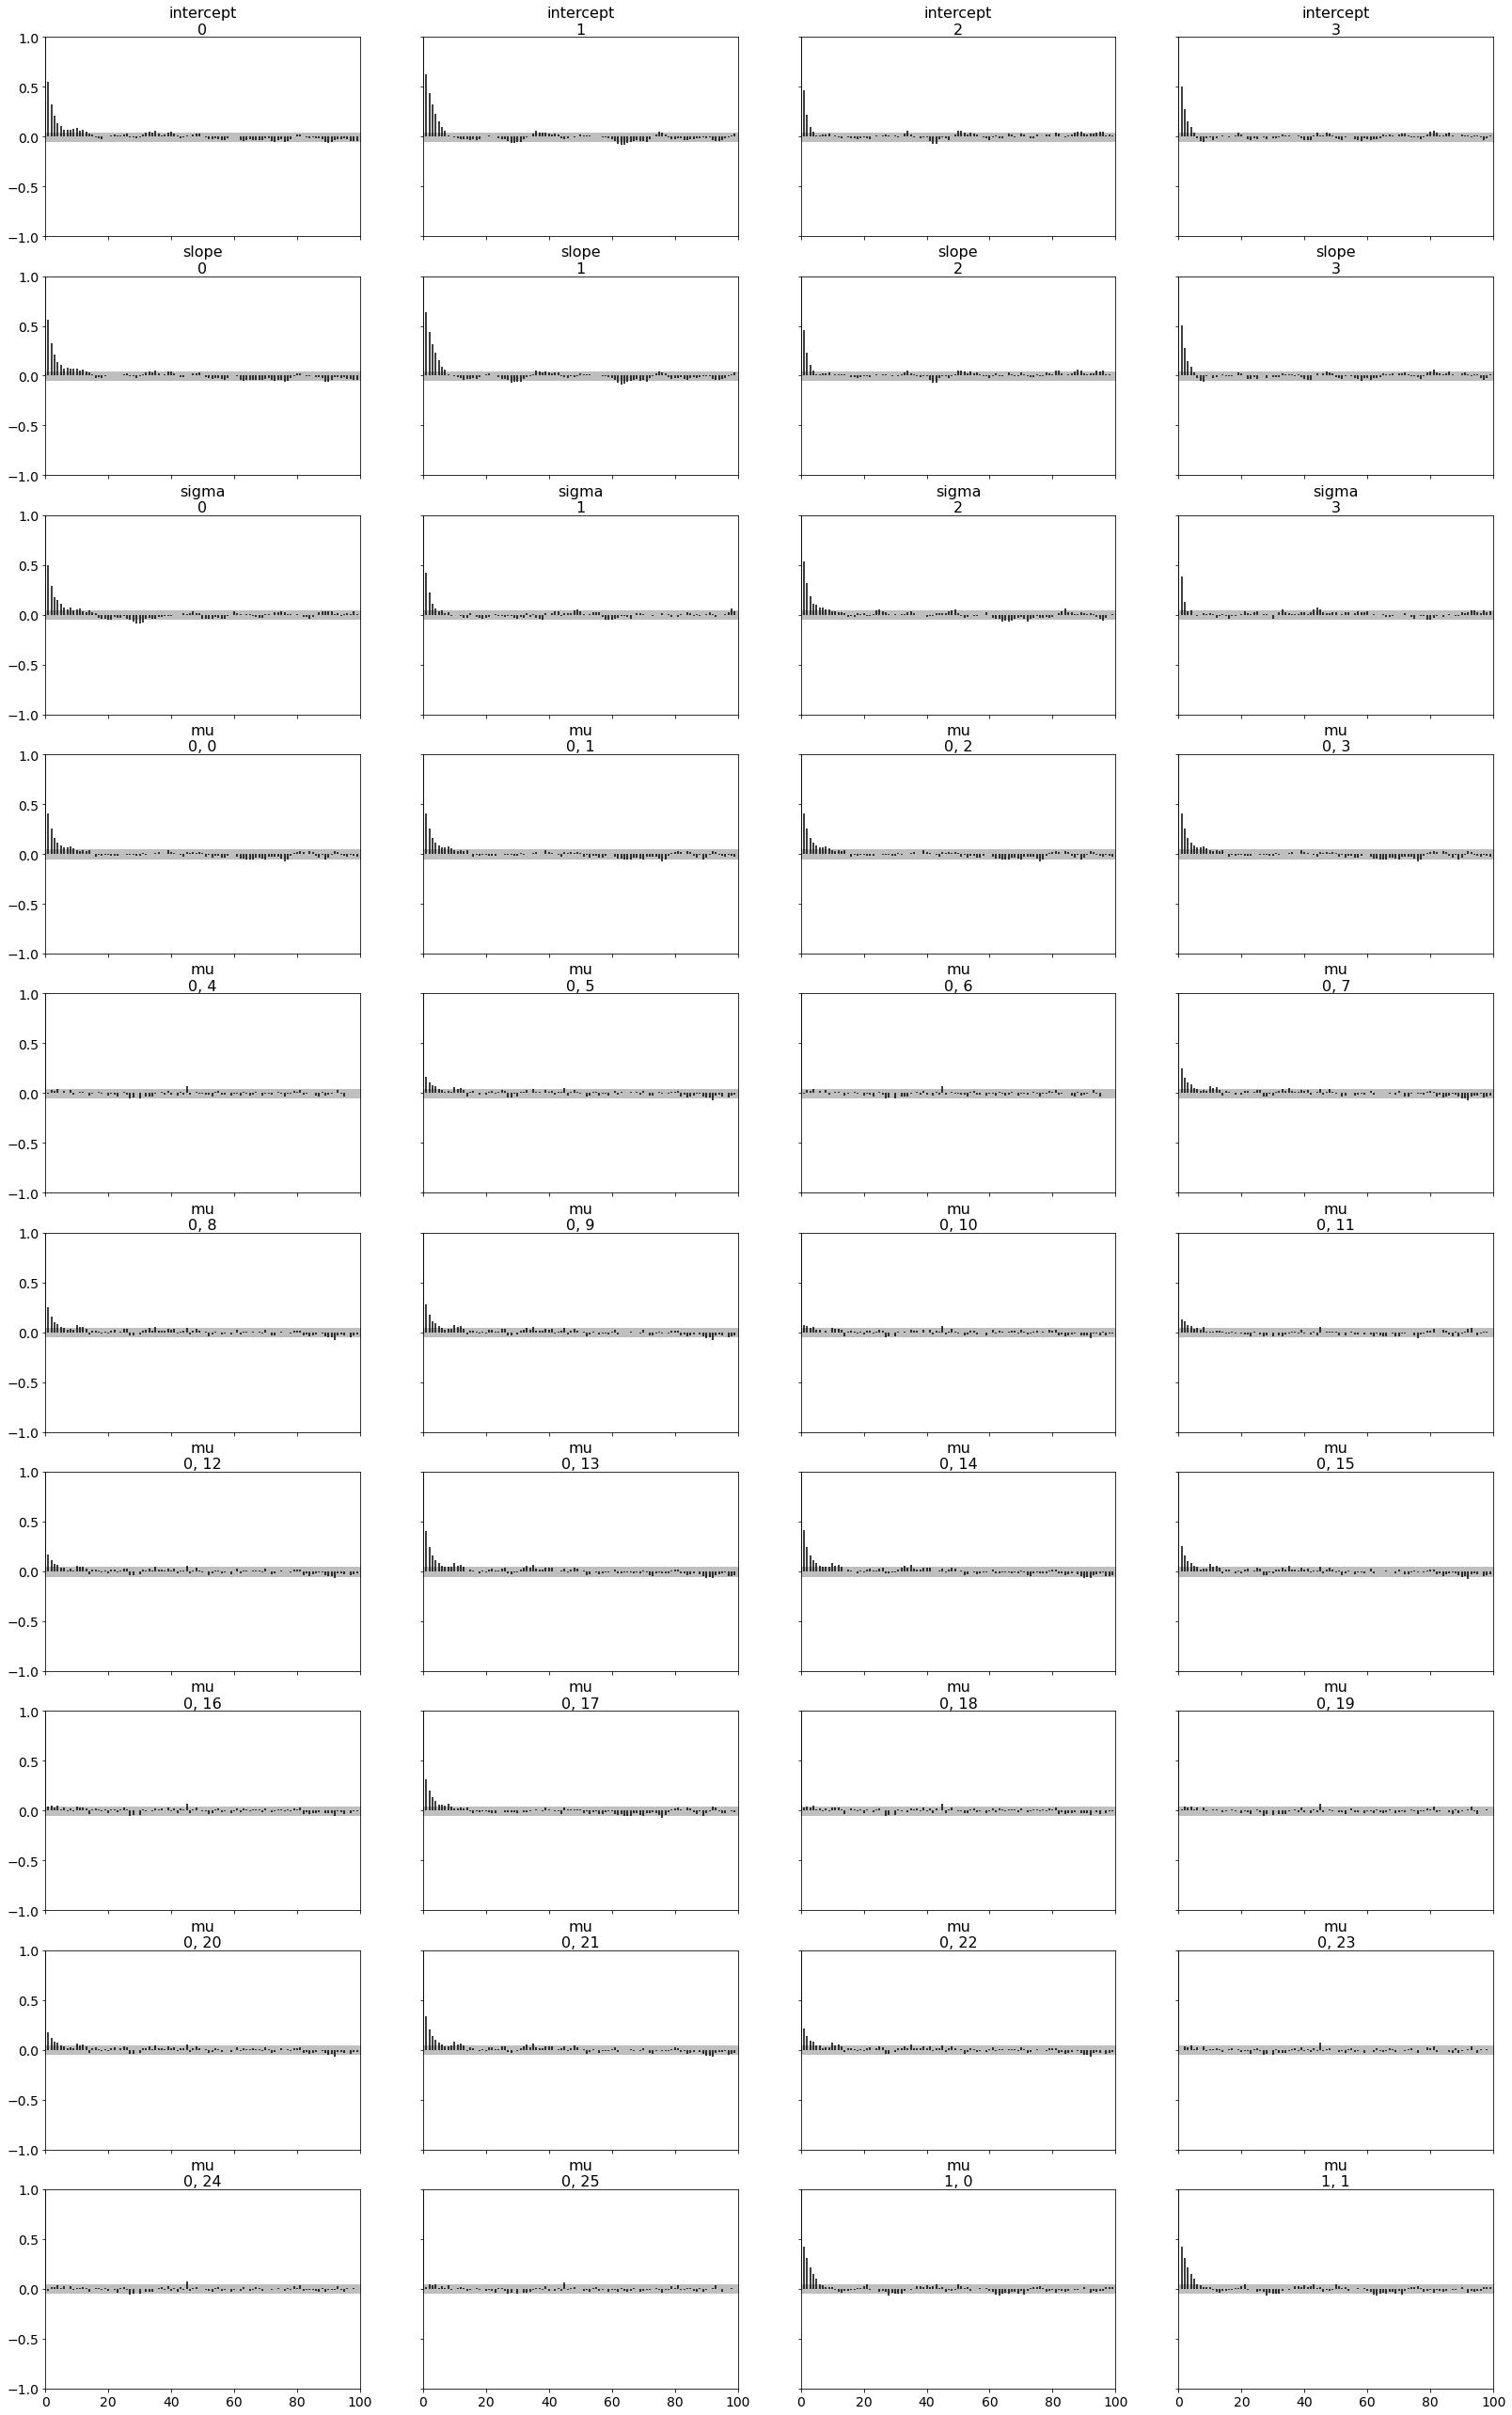

In [ ]:
pm.plot_autocorr(trace);

### Distribución posterior predictiva

Dada la luz de un puente, ¿podemos predecir la altura? 

Debido a que con las estadísticas bayesianas tratamos con distribuciones, no determinamos con un sólo valor predicho sino que contamos con una distribución de valores posibles.

Teniendo el posterior de los parámetros, podemos usarlo para calcular la **distribución posterior predictiva** en función de nuevos datos **X**.


$$p(\mathbf{y}| \mathbf{x,D}) = \int p(\mathbf{y} | \mathbf{x}, \theta)\ p(\theta|\mathbf{D})\ d\theta$$

donde en este caso $$ \theta = ( β_x, β_o, \sigma) $$ 

y se asume que **y** es condicionalmente independiente de **D** dado que conozco **θ**.

La parte más difícil era estimar **p(θ|D)**, el cual ya tenemos gracias a MCMC. Para obtener muestras del posterior predictivo, podemos usar nuestra traza con la función: `pm.sample_posterior_predictive()`.


In [ ]:
x_new = np.linspace(10, 35, num=2000)

with model:
    #Asignamos nuevos valores
    pm.set_data({'x': x_new})
    #keep_size establece la misma cantidad de valores de la muestra
    posterior_predictive = pm.sample_posterior_predictive(trace, keep_size=True, var_names=['mu', 'y_obs']) 
    

## Resultados

/usr/local/lib/python3.7/dist-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.7/dist-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.7/dist-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


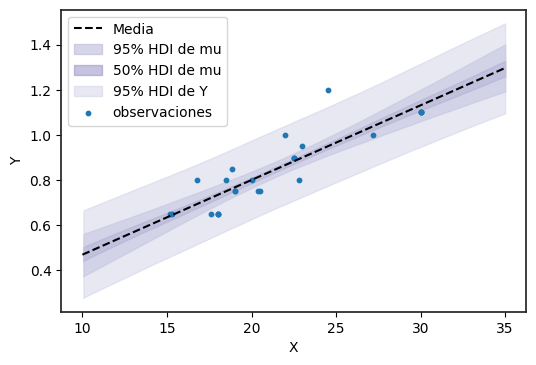

In [ ]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax.set_xlabel('X'); ax.set_ylabel('Y')

#Color
pal = sns.color_palette('Purples')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["axes.linewidth"]  = 1.25
plt.rcParams["axes.edgecolor"] = "0.15"

# Posterior de mu
mu_posterior = posterior_predictive.posterior_predictive.mu.stack(samples=('chain','draw'))
ax.plot( x_new, mu_posterior.mean('samples'), color='k', linestyle='--', label='Media' )
az.plot_hdi( x_new, mu_posterior.T, color=pal[2], hdi_prob=0.95, fill_kwargs={"label": "95% HDI de mu"})
az.plot_hdi( x_new, mu_posterior.T, color=pal[3], hdi_prob=0.5, fill_kwargs={"label": "50% HDI de mu"})

# Posterior predictiva de y
y_posterior = posterior_predictive.posterior_predictive.y_obs.stack(samples=('chain','draw'))
az.plot_hdi( x_new, y_posterior.T, color=pal[1], hdi_prob=0.95, fill_kwargs={"label": "95% HDI de Y"})

# Grafico las observaciones
ax.scatter(x, y, s=10, label='observaciones')

ax.legend()
plt.legend(frameon=True)
plt.show()

#Ejercicio 2

Ahora vamos a desarrollar un modelo con la data de las velocidades máximas mensuales registradas en la Ciudad de Buenos Aires. 

Para ello importamos el archivo:

In [ ]:
#Abrimos un archivo local, es decir, que ha sido descargado en su computadora
from google.colab import files
uploaded = files.upload()

Saving velocidad-max-viento-CABA.csv to velocidad-max-viento-CABA.csv


In [ ]:
#Se crea un DataFrame
df_vientos = pd.read_csv(io.BytesIO(uploaded['velocidad-max-viento-CABA.csv']))
df_vientos['periodo'] = df_vientos.index + 1
df_vientos.head()

,fecha,nudos,km/h,periodo
0,1991-01,38,70,1
1,1991-02,19,35,2
2,1991-03,32,59,3
3,1991-04,40,74,4
4,1991-05,26,48,5


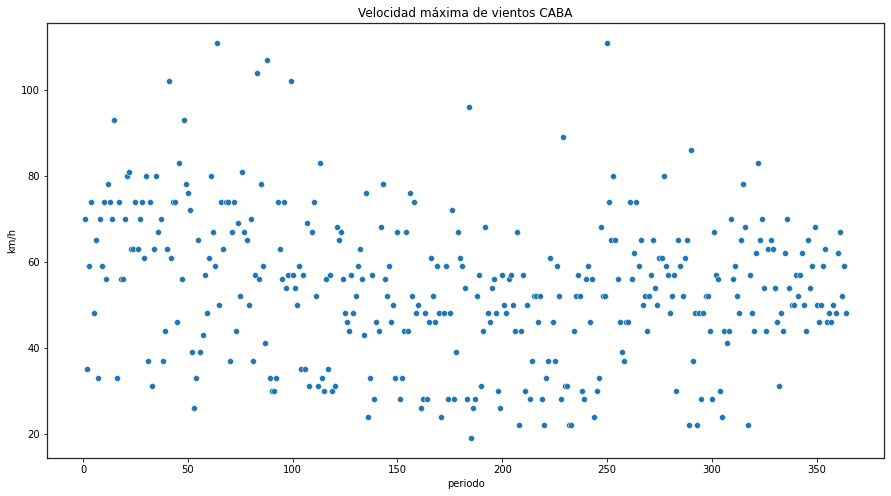

In [ ]:
#Gráfico:
plt.figure(figsize = (15,8))

ax = sns.scatterplot(data=df_vientos, x='periodo', y='km/h').set(title='Velocidad máxima de vientos CABA')

Como se puede observar, el modelo que queremos adaptar no es una línea perfecta entre **x** e **y**, de hecho, se espera que los parámetros del modelo varíen a lo largo de x. 

En estos casos, conviene realizar un ajuste por **spline**, es decir, una suma de múltiples curvas individuales (polinomios por partes), cada una ajustada a una sección diferente de **x** y que están unidas en sus **límites o nudos**.

La ventaja de los splines es que se obtienen resultados similares a las interpolaciones con polinomios de grados elevados, pero requiriendo polinomios de bajo grado, y así se evitan las oscilaciones, indeseables en la mayoría de las aplicaciones. Es decir, permite ajustar curvas de formas complicadas con curvas más simples y de menor costo computacional. 


## Preparar el Spline:
El spline tendrá 15 nudos, dividiendo el tiempo en 16 secciones que no serán iguales, sino que cada una contendrá la misma proporción de datos.

In [ ]:
num_knots = 15
knot_list = np.quantile(a=df_vientos['periodo'], q=np.linspace(0, 1, num_knots))

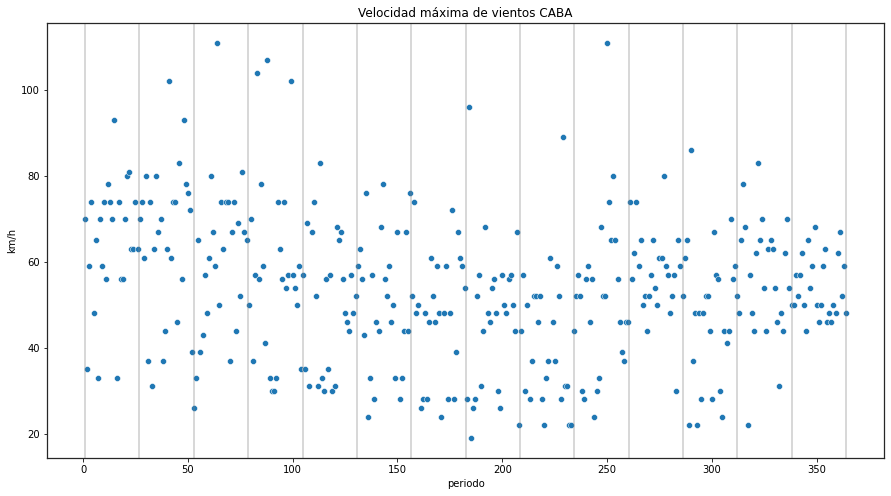

In [ ]:
plt.figure(figsize = (15,8))
ax = sns.scatterplot(data=df_vientos, x='periodo', y='km/h').set(title='Velocidad máxima de vientos CABA')

for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4);

Podemos usar patsy para crear la matriz que será la base B-spline para la regresión. 

El grado se establece en 3 para crear una b-spline cúbica.

In [ ]:
#from patsy import dmatrix

#B = dmatrix(
#    "bs(periodo, knots=knots, degree=3, include_intercept=True) - 1",
#    {"periodo": df_vientos['periodo'].values, "knots": knot_list[1:-1]},
#)
#B

In [ ]:
def bspline(x, k, i, t):
   if k == 0:
      return 1.0*( np.logical_and(x>=t[i],x<t[i+1]) ) + 0
      # return 1.0 if t[i] <= x < t[i+1] else 0.0
   if t[i+k] == t[i]:
      c1 = 0.0
   else:
      c1 = (x - t[i])/(t[i+k] - t[i]) * bspline(x, k-1, i, t)
   if t[i+k+1] == t[i+1]:
      c2 = 0.0
   else:
      c2 = (t[i+k+1] - x)/(t[i+k+1] - t[i+1]) * bspline(x, k-1, i+1, t)
   return c1 + c2

def Bspline( x, i, knots, degree=3 ):
    knots_ext = degree*[knots[0]] + knots + degree*[knots[-1]]
    return bspline( x, degree, i, knots_ext )

Nk = len(knot_list)
degree = 3
B0 = np.array([Bspline( df_vientos['periodo'].values, i, list(knot_list), degree) for i in range(Nk+degree-1)])

La base b-spline se representa a continuación. La superposición entre las funciones significa que, en un momento dado, la función de regresión está influenciada por más de una función base. 

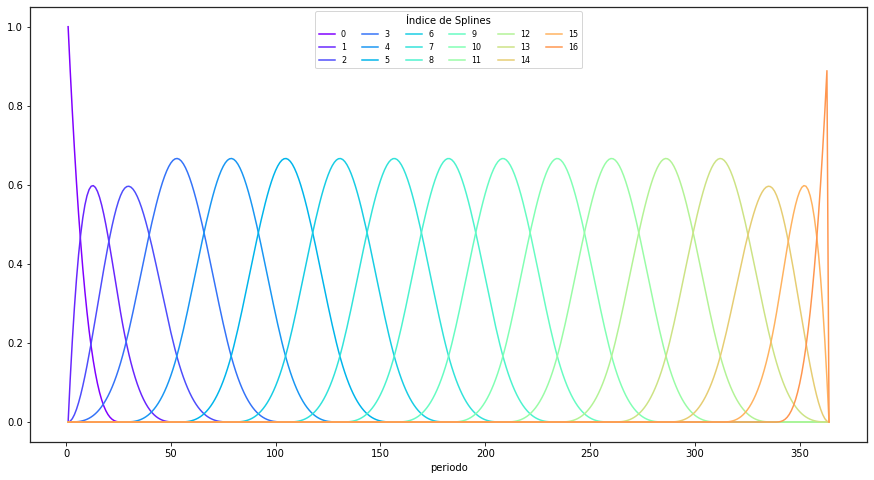

In [ ]:
spline_df = (
    pd.DataFrame(B0.T)
    .assign(periodo = df_vientos['periodo'].values)
    .melt("periodo", var_name="spline_i", value_name="valor")
)

color = plt.cm.rainbow(np.linspace(0, 0.80, len(spline_df.spline_i.unique())))

fig = plt.figure(figsize = (15,8))
for i, c in enumerate(color):
    subset = spline_df.query(f"spline_i == {i}")
    subset.plot("periodo", "valor", c=c, ax=plt.gca(), label=i)
plt.legend(title="Índice de Splines", loc="upper center", fontsize=8, ncol=6);

##Modelo:

Se ajustará el siguiente modelo para **Y**, correspondiente a la velocidad máxima: 

$$ Y_i \sim N \left( \mu_i, \sigma \right) $$

siendo:
$$ \mu_i = a+\sum_{k=1}^{K}β_{k}B_{k,i}$$ 

Esto significa que para cada observación i, la media está influenciada por todas las funciones base (desde **k=1** hasta **k=K**), más un intercepto **a**. Lo valores de  **β** en la sumatoria son los coeficientes de regresión de cada una de las funciones base, y el **B** son los valores de las funciones base.

Finalmente, se usarán las siguientes priors:

$$ a \sim N \left( 60, 10 \right) $$
$$ β \sim N \left( 0, 10 \right) $$
$$ \sigma \sim Exp \left( 1\right) $$


In [ ]:
with pm.Model() as spline_model:

    a = pm.Normal(name="a", mu=60, sigma=10)
    beta = pm.Normal(name="beta", mu=0, sigma=10, size=B0.shape[0])

    # mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w))
    mu = pm.Deterministic("mu", a + pm.math.dot( B0.T, beta ))

    sigma = pm.Exponential(name="sigma", lam=1)

    Y = pm.Normal("Y", mu=mu, sigma=sigma, observed=df_vientos['km/h'])


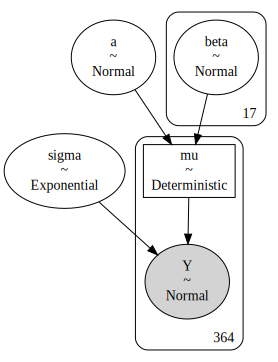

In [ ]:
pm.model_to_graphviz(spline_model)

Se toman 2000 muestras de la distribución posterior y se calculan las predicciones posteriores.

In [ ]:
with spline_model:
    trace = pm.sample(2000, tune=2000, chains=2, return_inferencedata=True)
    _ = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

## Análisis

Ahora podemos analizar las muestras del posterior con una tabla.

que resume las distribuciones posteriores de los parámetros del modelo. 

Los posteriores de **a** y **sigma** son bastante estrechos mientras que los de **β** son más anchos. Esto es probable porque todos los puntos de datos se usan para estimar a y sigma mientras que solo se usa un subconjunto para cada valor de β. 

El tamaño de muestra y los valores de **r_hat** son correctos, lo que indica que el modelo ha convergido y muestreado bien la distribución posterior.

In [ ]:
az.summary(trace, var_names=["a", "beta", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,54.813,2.508,50.150,59.592,0.059,0.042,1826.0,2239.0,1.0
beta[0],0.603,6.730,-11.906,12.776,0.113,0.114,3579.0,2822.0,1.0
beta[1],10.103,6.718,-1.779,23.028,0.108,0.080,3879.0,3077.0,1.0
beta[2],10.852,6.325,-1.518,22.273,0.105,0.077,3608.0,3158.0,1.0
beta[3],5.075,5.673,-5.438,15.547,0.102,0.077,3089.0,2949.0,1.0
beta[4],9.430,5.518,-0.609,20.021,0.098,0.070,3175.0,3233.0,1.0
beta[5],-2.673,5.585,-13.108,7.471,0.098,0.073,3252.0,3156.0,1.0
beta[6],-3.296,5.579,-13.577,7.004,0.098,0.076,3219.0,2809.0,1.0
beta[7],-5.734,5.623,-15.343,5.375,0.099,0.075,3227.0,3011.0,1.0
beta[8],-6.137,5.672,-16.837,4.322,0.102,0.072,3136.0,2868.0,1.0


Los trace plots de los parámetros del modelo se ven bien (homogéneos y sin signos de tendencia), lo que indica además que las cadenas convergieron y se mezclaron.

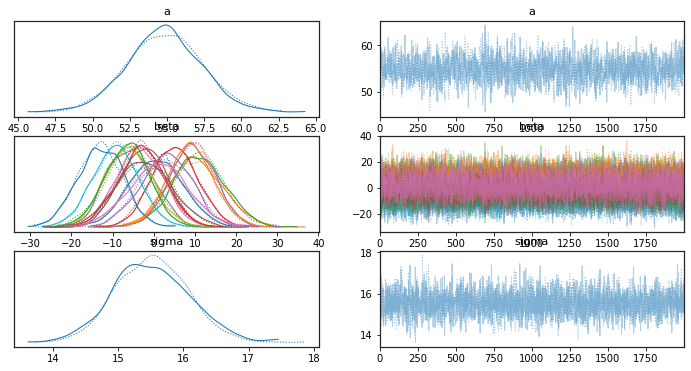

In [ ]:
az.plot_trace(trace, var_names=["a", "beta", "sigma"]);


Un forest plot muestra que las distribuciones de los valores de **β** son más grandes, aunque algunos se alejan principalmente de 0, lo que indica un efecto/asociación no nulo.

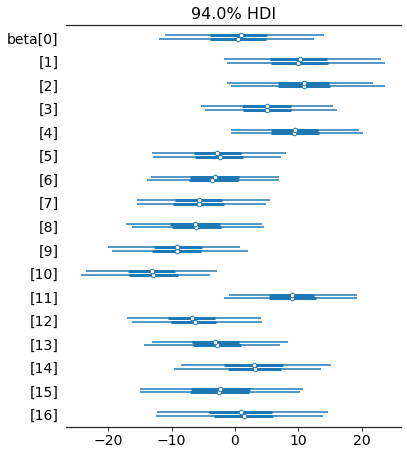

In [ ]:
az.plot_forest(trace, var_names=["beta"], combined=False);

Por último, podemos visualizar los valores de los spline de ajuste multiplicados por la matriz base.

Los nudos se muestran nuevamente como líneas verticales, pero ahora la base de la spline **B** se multiplica por los valores de **β** (representados como las curvas con los colores del arco iris). El producto punto de **B** y **β**, el cálculo real en el modelo lineal, se muestra en negro.

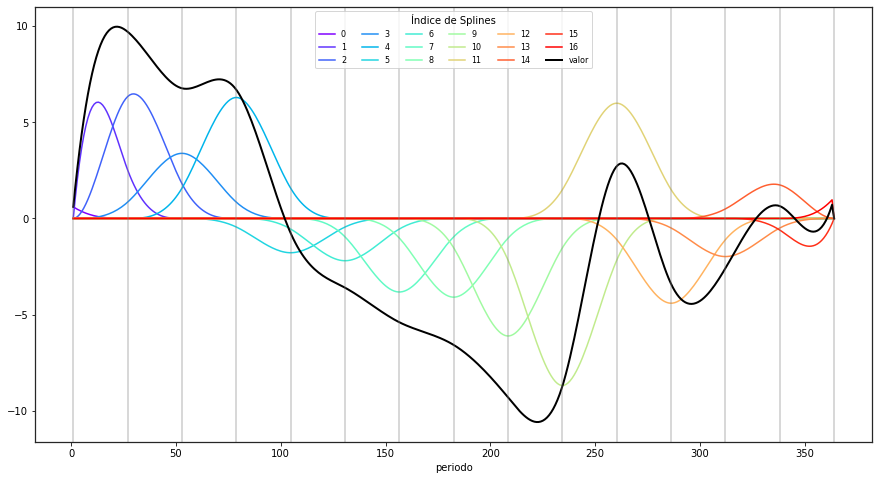

In [ ]:
beta_p = trace.posterior["beta"].mean(("chain", "draw")).values

spline_df = (
    pd.DataFrame(B0.T * beta_p.T)
    .assign(periodo = df_vientos['periodo'].values)
    .melt("periodo", var_name="spline_i", value_name="valor")
)


spline_df_merged = (
    pd.DataFrame(np.dot(B0.T, beta_p.T))
    .assign(periodo = df_vientos['periodo'].values)
    .melt("periodo", var_name="spline_i", value_name="valor")
)

color = plt.cm.rainbow(np.linspace(0, 1, len(spline_df.spline_i.unique())))

fig = plt.figure(figsize = (15,8))
for i, c in enumerate(color):
    subset = spline_df.query(f"spline_i == {i}")
    subset.plot("periodo", "valor", c=c, ax=plt.gca(), label=i)
spline_df_merged.plot("periodo", "valor", c="black", lw=2, ax=plt.gca())
plt.legend(title="Índice de Splines", loc="upper center", fontsize=8, ncol=6)

for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4);


##Modelo de predicciones
Por último, podemos visualizar las predicciones del modelo.

In [ ]:
post_pred = az.summary(trace, var_names=["mu"]).reset_index(drop=True)

df_vientos_post = df_vientos.copy().reset_index(drop=True)
df_vientos_post["pred_mean"] = post_pred["mean"]
df_vientos_post["pred_hdi_lower"] = post_pred["hdi_3%"]
df_vientos_post["pred_hdi_upper"] = post_pred["hdi_97%"]
df_vientos_post.head()

,fecha,nudos,km/h,periodo,pred_mean,pred_hdi_lower,pred_hdi_upper
0,1991-01,38,70,1,55.416,43.116,67.581
1,1991-02,19,35,2,56.475,45.396,66.469
2,1991-03,32,59,3,57.455,48.186,66.289
3,1991-04,40,74,4,58.359,49.985,66.001
4,1991-05,26,48,5,59.190,52.215,66.725


In [ ]:
y_pred = az.summary(trace.posterior_predictive, var_names=["Y"]).reset_index(drop=True)

# df_vientos_post = df_vientos.copy().reset_index(drop=True)
df_vientos_post["y_pred_mean"] = y_pred["mean"]
df_vientos_post["y_pred_hdi_lower"] = y_pred["hdi_3%"]
df_vientos_post["y_pred_hdi_upper"] = y_pred["hdi_97%"]
df_vientos_post.head()

,fecha,nudos,km/h,periodo,pred_mean,pred_hdi_lower,pred_hdi_upper,y_pred_mean,y_pred_hdi_lower,y_pred_hdi_upper
0,1991-01,38,70,1,55.416,43.116,67.581,55.387,25.219,87.882
1,1991-02,19,35,2,56.475,45.396,66.469,56.816,24.777,87.352
2,1991-03,32,59,3,57.455,48.186,66.289,57.039,26.624,86.437
3,1991-04,40,74,4,58.359,49.985,66.001,58.289,26.846,87.894
4,1991-05,26,48,5,59.190,52.215,66.725,58.817,27.453,88.765


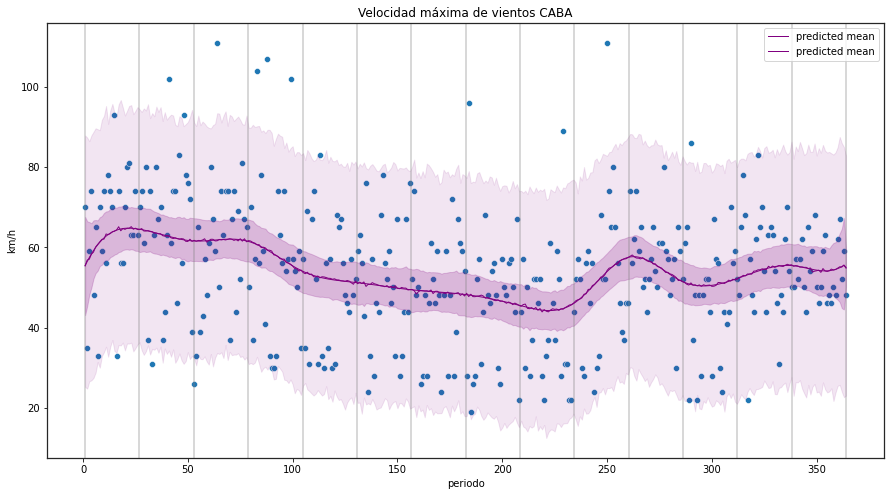

In [ ]:
plt.figure(figsize = (15,8))

ax = sns.scatterplot(data=df_vientos, x='periodo', y='km/h').set(title='Velocidad máxima de vientos CABA')

for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4)

ax = sns.lineplot(data=df_vientos_post, x='periodo', y="pred_mean", ax=plt.gca(), lw=1, color="purple", label='predicted mean')

plt.fill_between(
    df_vientos_post['periodo'],
    df_vientos_post['pred_hdi_lower'],
    df_vientos_post['pred_hdi_upper'],
    color="purple",
    alpha=0.2,
);

ax = sns.lineplot(data=df_vientos_post, x='periodo', y="y_pred_mean", ax=plt.gca(), lw=1, color="purple", label='predicted mean')

plt.fill_between(
    df_vientos_post['periodo'],
    df_vientos_post["y_pred_hdi_lower"],
    df_vientos_post["y_pred_hdi_upper"],
    color="purple",
    alpha=0.1,
);

¿Qué ocurre si modificamos la cantidad de puntos?